In [1]:
import copy
from datetime import datetime
import logging
import os
import time
from pathlib import Path

import matplotlib

# matplotlib.use("TkAgg")  # no UI backend
import pickle

import numpy as np
import timm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from pytorch_grad_cam import (
    AblationCAM,
    EigenCAM,
    FullGrad,
    GradCAM,
    GradCAMPlusPlus,
    HiResCAM,
    ScoreCAM,
    XGradCAM,
)
from pytorch_grad_cam.utils.image import (
    deprocess_image,
    preprocess_image,
    show_cam_on_image,
)
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm
from operator import attrgetter

from proxyattention.data_utils import (
    clear_proxy_images,
    create_dls,
    create_folds,
    get_parent_name,
)
from proxyattention.meta_utils import get_files, save_pickle, read_pickle, return_grouped_results, fix_tensorboard_names
from proxyattention.training import choose_network, dict_gradient_method, inv_normalize, find_target_layer

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import time
import gc
import copy
import argparse as ap
import ast
import pandas as pd
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst


import cv2
import matplotlib.pyplot as plt

# sns.set()

cudnn.benchmark = True

computer_choice = "pc"
config = {}
# pc, cluster

# Make dirs
if computer_choice == "linux":
    main_run_dir = (
        "/run/media/eragon/HDD/CODE/Github/improving_robotics_datasets/src/runs/"
    )
    main_ds_dir = "/run/media/eragon/HDD/Datasets/"
    config["device"] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

elif computer_choice == "pc":
    main_run_dir = Path(
        "/mnt/d/CODE/thesis_runs/proper_runs/"
    )
    main_ds_dir = Path("/mnt/d/Datasets/")
    config["device"] = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ds_val_paths = {
    "asl": {
        "path" : f"{main_ds_dir}/asl/asl_alphabet_test/",
        "name_func": lambda x: x.split("/")[-1].split("_")[0],
    },
    "cifar100": {
        "path" : f"{main_ds_dir}/CIFAR-100/test",
        "name_func": get_parent_name,},
    "imagenette": {
        "path" : f"{main_ds_dir}/imagenette2-320/val",
        "name_func": get_parent_name,
    },
    "caltech256": {
        "path" : f"{main_ds_dir}/caltech256/valid",
        "name_func": get_parent_name,
    },
    # "dogs": {
    #     "path": "/run/media/eragon/HDD/Datasets/dogs/test",
    #     "name_func": get_parent_name,
    # }, #todo
    # "plantdisease": {
    #     "path": "/run/media/eragon/HDD/Datasets/plantdisease/test",
    #     "name_func": get_parent_name,
    # }, #todo
}

os.environ["TORCH_HOME"] = str(main_ds_dir)


/home/eragon/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-16 15:04:04.740061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 15:04:05.375645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
%matplotlib inline

In [2]:
read_agg_res = read_pickle("./results/aggregated_runs.csv")[0]
read_agg_res = fix_tensorboard_names(read_agg_res)

/mnt/c/Users/msubh/Documents/Github/proxy_attention/src/proxyattention/meta_utils.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(totype)


In [3]:
read_agg_res.head()

,index,proxy_step,Loss/Train,Acc/Train,global_run_count,Loss/Val,accuracy,experiment_name,image_size,batch_size,...,label_map,rev_label_map,num_classes,dataset_sizes,criterion,cam,save_path,final_acc,Number_Chosen,has_proxy
0,/mnt/d/CODE/thesis_runs/proper_runs/baseline_r...,False,0.000079,99.912529,20,0.007058,88.954506,baseline_run,224,64,...,"{0: 'BACKGROUND_Google', 1: 'Faces', 2: 'Faces...","{'BACKGROUND_Google': 0, 'Faces': 1, 'Faces_ea...",102,"{'train': 4573, 'val': 4572}",CrossEntropyLoss(),<pytorch_grad_cam.grad_cam_plusplus.GradCAMPlu...,/run/media/eragon/HDD/CODE/Github/improving_ro...,88.95450568678915,0.0,False
1,/mnt/d/CODE/thesis_runs/proper_runs/baseline_r...,False,0.001030,99.430000,20,0.046147,65.949997,baseline_run,224,32,...,"{0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3:...","{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'b...",100,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),<pytorch_grad_cam.grad_cam_plusplus.GradCAMPlu...,/run/media/eragon/HDD/CODE/Github/improving_ro...,65.95,0.0,False
2,/mnt/d/CODE/thesis_runs/proper_runs/baseline_r...,False,0.000502,99.459999,20,0.024097,63.660000,baseline_run,224,64,...,"{0: 'n02085620-Chihuahua', 1: 'n02085782-Japan...","{'n02085620-Chihuahua': 0, 'n02085782-Japanese...",120,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),<pytorch_grad_cam.grad_cam_plusplus.GradCAMPlu...,/run/media/eragon/HDD/CODE/Github/improving_ro...,63.66,0.0,False
3,/mnt/d/CODE/thesis_runs/proper_runs/baseline_r...,False,0.000007,100.000000,20,0.000001,100.000000,baseline_run,224,64,...,"{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F...","{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': ...",20,"{'train': 10000, 'val': 10000}",CrossEntropyLoss(),<pytorch_grad_cam.grad_cam_plusplus.GradCAMPlu...,/run/media/eragon/HDD/CODE/Github/improving_ro...,100.0,0.0,False
4,/mnt/d/CODE/thesis_runs/proper_runs/baseline_r...,False,0.000112,99.873283,20,0.003803,93.409378,baseline_run,224,64,...,"{0: 'n01440764', 1: 'n02102040', 2: 'n02979186...","{'n01440764': 0, 'n02102040': 1, 'n02979186': ...",10,"{'train': 4735, 'val': 4734}",CrossEntropyLoss(),<pytorch_grad_cam.grad_cam_plusplus.GradCAMPlu...,/run/media/eragon/HDD/CODE/Github/improving_ro...,93.40937896070976,0.0,False


In [4]:
return_grouped_results(read_agg_res, ["index","ds_name", "model", "global_run_count", "final_acc", "save_path","has_proxy", "step_schedule"], filter={"ds_name": "cifar100", "model":"resnet18"})


,,,,,,,,accuracy
index,ds_name,model,global_run_count,final_acc,save_path,has_proxy,step_schedule,
/mnt/d/CODE/thesis_runs/proper_runs/proxy_run_28032023_092528/events.out.tfevents.1679988566.eragon,cifar100,resnet18,21,79.22,/run/media/eragon/HDD/CODE/Github/improving_robotics_datasets/src/runs/proxy_run_28032023_092528/checkpoint,True,"[10, 'p', 10]",79.220001
/mnt/d/CODE/thesis_runs/proper_runs/proxy_run_28032023_091102/events.out.tfevents.1679987690.eragon,cifar100,resnet18,21,79.16,/run/media/eragon/HDD/CODE/Github/improving_robotics_datasets/src/runs/proxy_run_28032023_091102/checkpoint,True,"[10, 'p', 10]",79.160004
/mnt/d/CODE/thesis_runs/proper_runs/proxy_run_28032023_121818/events.out.tfevents.1679998967.eragon,cifar100,resnet18,21,79.16,/run/media/eragon/HDD/CODE/Github/improving_robotics_datasets/src/runs/proxy_run_28032023_121818/checkpoint,True,"[10, 'p', 10]",79.160004
/mnt/d/CODE/thesis_runs/proper_runs/proxy_run_28032023_113403/events.out.tfevents.1679996284.eragon,cifar100,resnet18,21,79.12,/run/media/eragon/HDD/CODE/Github/improving_robotics_datasets/src/runs/proxy_run_28032023_113403/checkpoint,True,"[10, 'p', 10]",79.120003
/mnt/d/CODE/thesis_runs/proper_runs/proxy_run_28032023_112625/events.out.tfevents.1679995826.eragon,cifar100,resnet18,21,79.07,/run/media/eragon/HDD/CODE/Github/improving_robotics_datasets/src/runs/proxy_run_28032023_112625/checkpoint,True,"[10, 'p', 10]",79.070000
/mnt/d/CODE/thesis_runs/proper_runs/proxy_run_28032023_122706/events.out.tfevents.1679999510.eragon,cifar100,resnet18,21,78.67,/run/media/eragon/HDD/CODE/Github/improving_robotics_datasets/src/runs/proxy_run_28032023_122706/checkpoint,True,"[10, 'p', 10]",78.669998
/mnt/d/CODE/thesis_runs/proper_runs/proxy_run_28032023_090406/events.out.tfevents.1679987266.eragon,cifar100,resnet18,21,78.56,/run/media/eragon/HDD/CODE/Github/improving_robotics_datasets/src/runs/proxy_run_28032023_090406/checkpoint,True,"[10, 'p', 10]",78.559998
/mnt/d/CODE/thesis_runs/proper_runs/proxy_run_28032023_091810/events.out.tfevents.1679988123.eragon,cifar100,resnet18,21,78.47,/run/media/eragon/HDD/CODE/Github/improving_robotics_datasets/src/runs/proxy_run_28032023_091810/checkpoint,True,"[10, 'p', 10]",78.470001
/mnt/d/CODE/thesis_runs/proper_runs/proxy_run_28032023_091102/events.out.tfevents.1679987655.eragon,cifar100,resnet18,11,76.76,/run/media/eragon/HDD/CODE/Github/improving_robotics_datasets/src/runs/proxy_run_28032023_091102/checkpoint,True,"[10, 'p', 10]",76.760002


In [5]:
index_check = ["/mnt/d/CODE/thesis_runs/proper_runs/proxy_run_28032023_092528/events.out.tfevents.1679988566.eragon", "/mnt/d/CODE/thesis_runs/proper_runs/baseline_run_26032023_124800/events.out.tfevents.1679827680.eragon"]

In [6]:
def get_row_from_index(read_agg_res, index_check):
    temp_df = read_agg_res[read_agg_res["index"] == index_check]
    model_name = temp_df["model"].values[0]
    save_path = (
        temp_df["save_path"]
        .values[0]
        .replace("improving_robotics_datasets", "proxy_attention")
    )
    num_classes = temp_df["num_classes"].values[0]
    ds_name = temp_df["ds_name"].values[0]

    model = timm.create_model(
    model_name=model_name,
    pretrained=True,
    num_classes=int(num_classes),
    )

    sd = model.state_dict()

    model = timm.create_model(
        model_name=model_name,
        pretrained=True,
        num_classes=int(num_classes),
    ).to("cuda")

    model.load_state_dict(sd)
    model.eval()

    return model_name, save_path, num_classes, ds_name, model

In [7]:
def get_single_cam(compare):
    target_layer = find_target_layer(config={"model": compare[0]}, model = compare[-1])

    return GradCAMPlusPlus(
        model=compare[-1].cpu(), target_layers=target_layer, use_cuda=False
    )


In [8]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

tfm = transforms.ToPILImage()

In [9]:
compare_1, compare_2 = get_row_from_index(read_agg_res, index_check[0]), get_row_from_index(read_agg_res, index_check[1])
ds_name = compare_1[-2]

In [10]:
cam_1, cam_2 = get_single_cam(compare_1), get_single_cam(compare_2)

In [82]:
ds_val_path = ds_val_paths[ds_name]["path"]
ds_val_name_func = ds_val_paths[ds_name]["name_func"]
# Create an ImageFolder dataset using the images_folder_path
dataset = ImageFolder(ds_val_path, transform=transform)

# Create a DataLoader for the dataset
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
dataloader


In [83]:
dataloader = iter(dataloader)

In [108]:
image, _ = next(iter(dataloader))
# image = image.to("cuda")

In [91]:
#cam1 has proxy while cam2 does not
grads_1 = cam_1(input_tensor=image, targets=None)
grads_2 = cam_2(input_tensor=image, targets=None)

In [104]:


def show_cam_on_image(image, mask, weight = 0.6):
    mask,current_image, colormap = deprocess_image(tfm(mask)), image, cv2.COLORMAP_JET
    current_image = current_image.permute(1, 2, 0).cpu().numpy()
    # image = np.asarray(image)
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    # heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    cam = (1 - weight) * heatmap + weight * current_image
    cam = cam / np.max(cam)
    im = np.uint8(255 * cam)
    return Image.fromarray(im)


In [105]:
def plot_images(image, grads, title="noproxy"):

    cams = [show_cam_on_image(image[i], grads[i]) for i in range(len(image))]
    rows = 4
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(10,10))

    for i in range(rows):
        for j in range(cols):
            img_index = i*cols + j
            if img_index < len(cams):
                axes[i][j].imshow(cams[img_index])
                axes[i][j].set_title(title)
            axes[i][j].axis('off')
    # plt.show()
    return plt

<module 'matplotlib.pyplot' from '/home/eragon/miniforge3/lib/python3.10/site-packages/matplotlib/pyplot.py'>

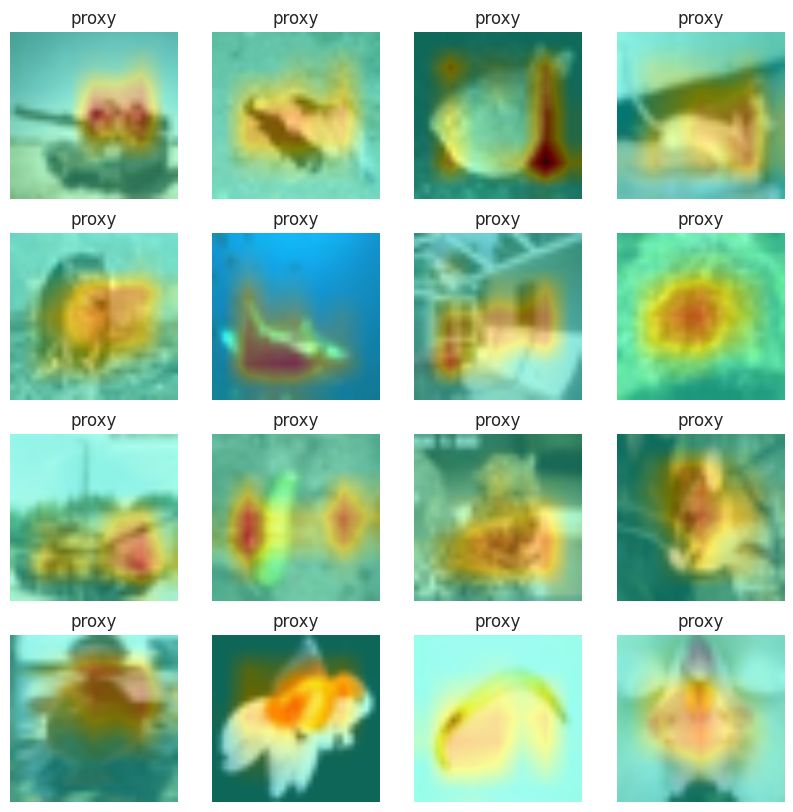

In [109]:

plot_images(image, grads_1, title="proxy")

<module 'matplotlib.pyplot' from '/home/eragon/miniforge3/lib/python3.10/site-packages/matplotlib/pyplot.py'>

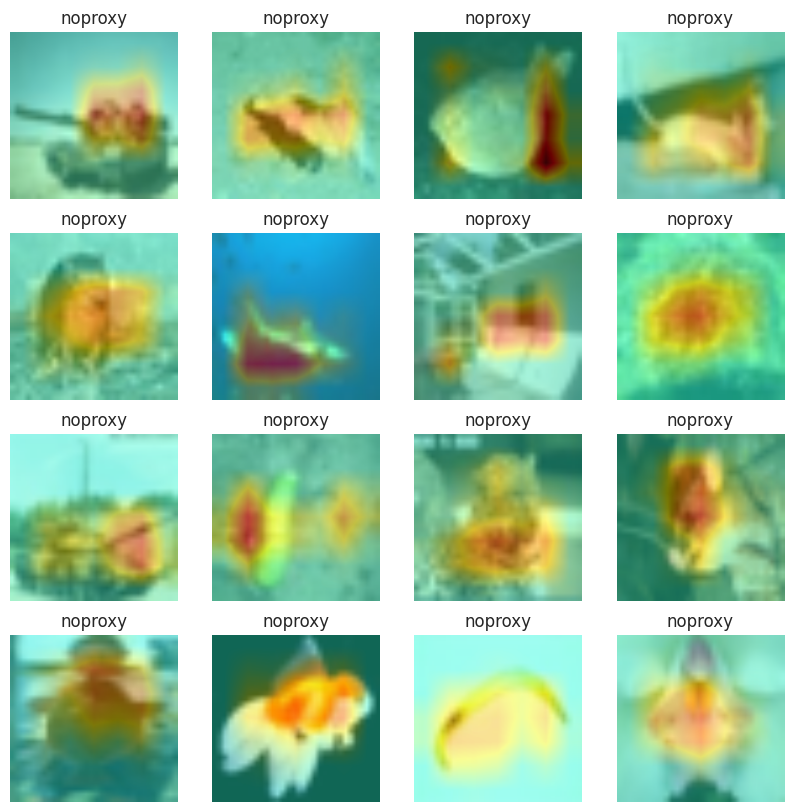

In [110]:
plot_images(image, grads_2, title="noproxy")